***
### 0. Thiết lập SparkSession

In [1]:
import findspark
findspark.init()
import seaborn as sns

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkML').getOrCreate()
spark

In [3]:
# Dữ liệu Huấn luyện mô hình
train_df = spark.read.csv("C:/Users/ADMIN/Desktop/DungPyspark/train.csv", header = True, inferSchema = True)
train_df.show(3)

+------+-----------+--------+-------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|    ID|Customer_ID|   Month|         Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+------+-----------+--------+-------------+----+-----------+------

In [5]:
# Xóa cột 'ID', 'Customer_ID'
train_df = train_df.drop('ID', 'Customer_ID', 'Name', 'SSN')
train_df.show(3)

+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   Monthly_Balance|Credit_Score|
+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------

In [148]:
# Kích thước dữ liệu và Schema
print(f"kích thước của dữ liệu train_df: {train_df.count()} dòng, {len(train_df.columns)} cột")
train_df.printSchema()

kích thước của dữ liệu train_df: 100000 dòng, 24 cột
root
 |-- Month: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: string (nullable = true)
 |-- Monthly_Inhand_Salary: double (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: integer (nullable = true)
 |-- Num_of_Loan: string (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: string (nullable = true)
 |-- Changed_Credit_Limit: string (nullable = true)
 |-- Num_Credit_Inquiries: double (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: string (nullable = true)
 |-- Credit_Utilization_Ratio: double (nullable = true)
 |-- Credit_History_Age: string (nullable = true)
 |-- Payment_of_Min_Amount: string (nullable = true)
 |-- Total_EMI_per_month: double (nullab

**Phân phối biến mục tiêu**

Phân phối của Biến mục tiêu: 
Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64


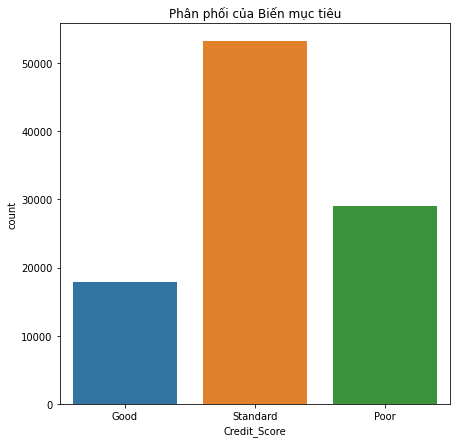

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

df = train_df.toPandas()
plt.figure(figsize = (7, 7))
print(f"Phân phối của Biến mục tiêu: \n{df['Credit_Score'].value_counts()}")
sns.countplot(x = "Credit_Score", data = df).set(title = 'Phân phối của Biến mục tiêu')
plt.show()

> **Chuyển nhã `Standard` thành nhã `Good` để mô hình tăng khả năng xác định nhãn `Poor`**

Phân phối của Biến mục tiêu: 
Credit_Score
Good    71002
Poor    28998
Name: count, dtype: int64


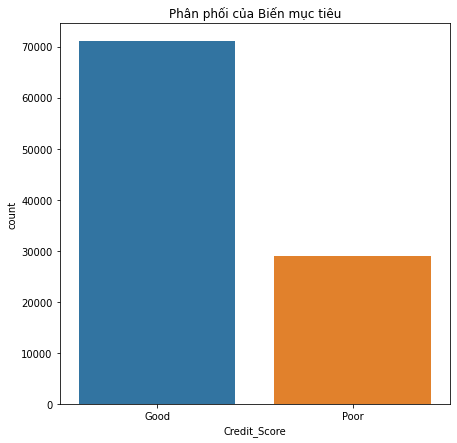

In [142]:
from pyspark.sql.functions import when
train_df = train_df.withColumn("Credit_Score", when(train_df["Credit_Score"] == "Standard", "Good").otherwise(train_df["Credit_Score"]))

df = train_df.toPandas()
plt.figure(figsize = (7, 7))
print(f"Phân phối của Biến mục tiêu: \n{df['Credit_Score'].value_counts()}")
sns.countplot(x = "Credit_Score", data = df).set(title = 'Phân phối của Biến mục tiêu')
plt.show()

**Kiểm tra dữ liệu khuyết**

In [6]:
from pyspark.sql.functions import isnan, when, count, col
train_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df.columns]).show()

+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
|Month|Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+-

<AxesSubplot:>

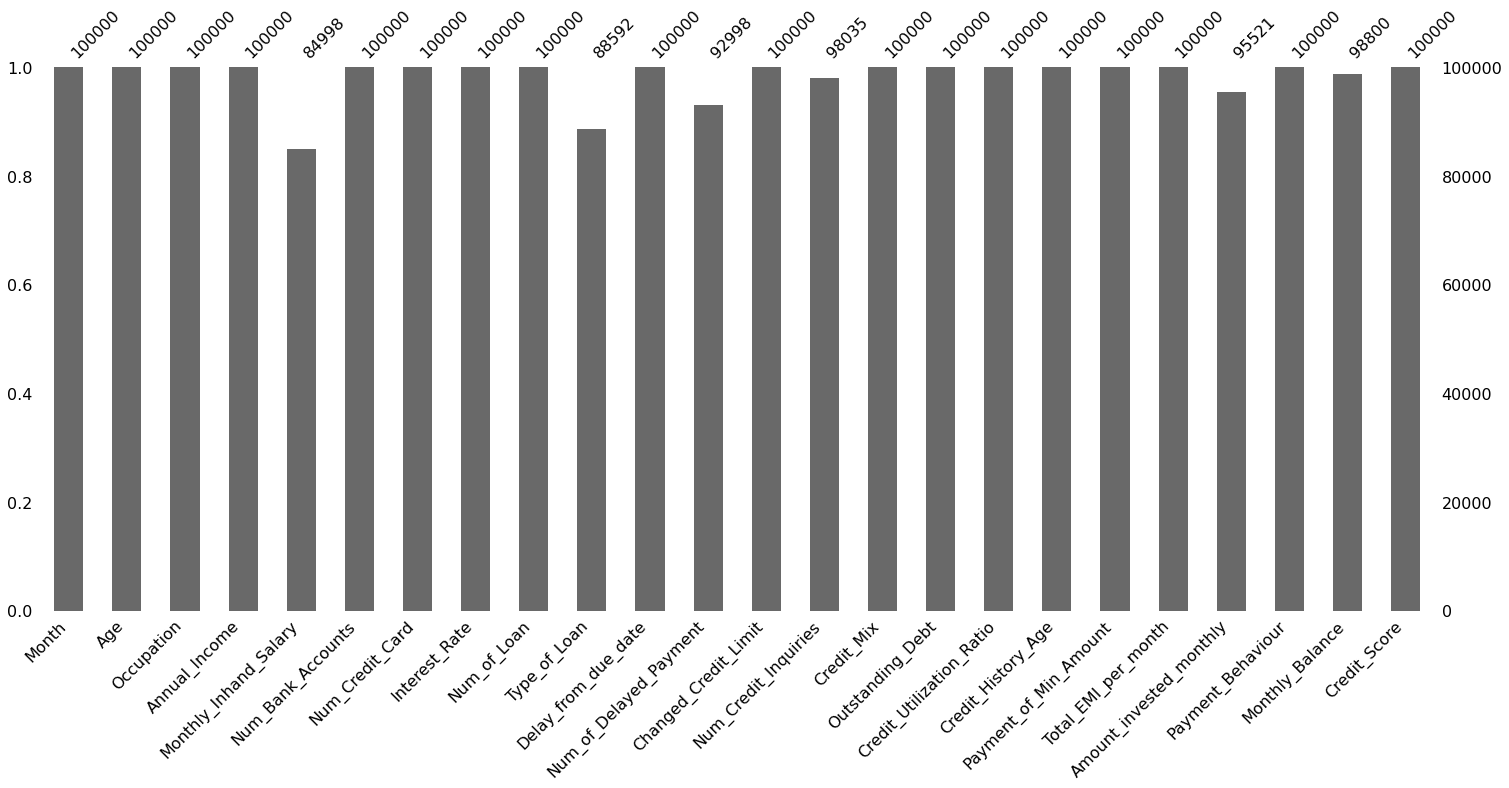

In [9]:
import missingno as msno
msno.bar(train_df.toPandas())

<AxesSubplot:>

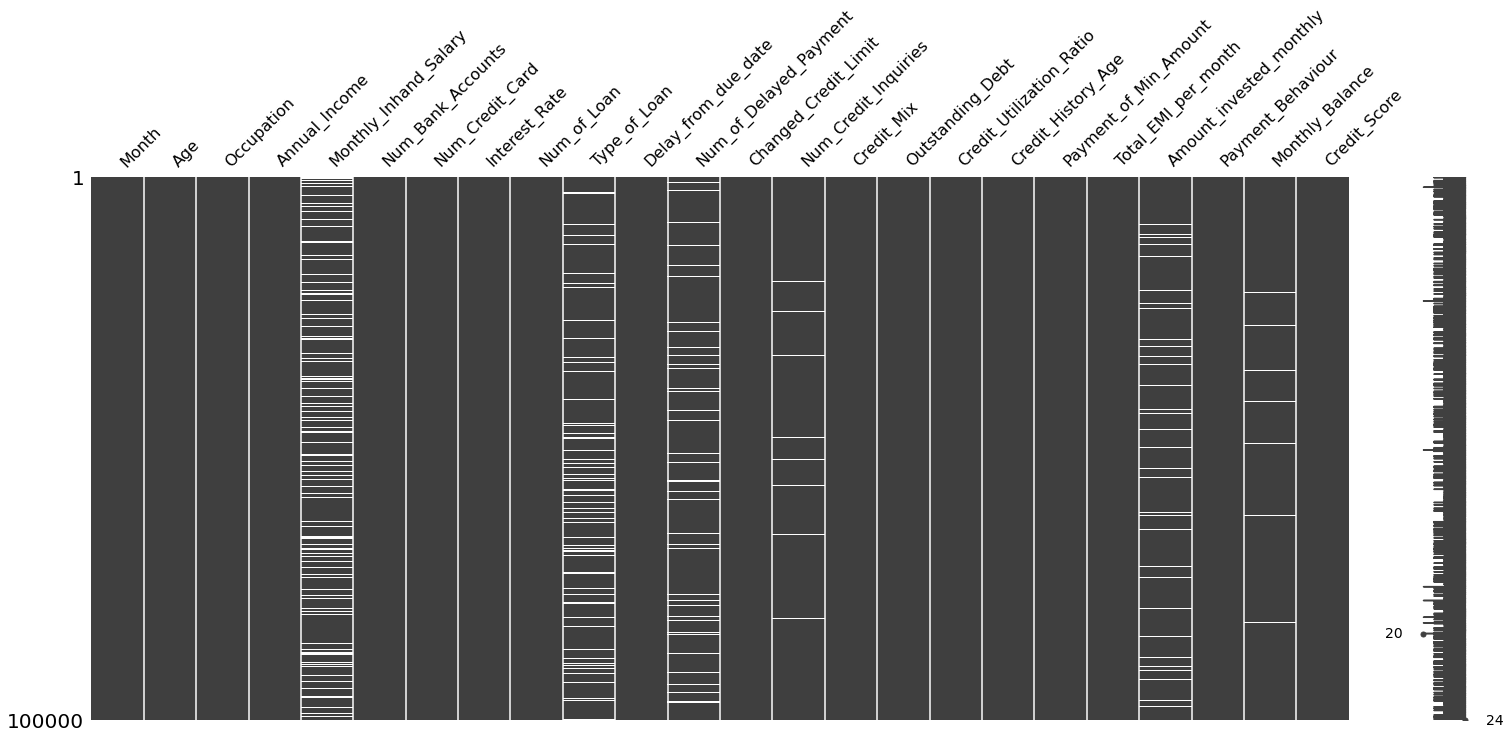

In [10]:
msno.matrix(train_df.toPandas())

**Kiểm tra dữ liệu khuyết**
- Nhìn qua 2 bảng được thống kê có thể thấy `không có giá trị nào bị khuyết.`

In [11]:
from pyspark.sql.functions import when, isnan, count, col, monotonically_increasing_id, round

def find_row_missing_percentage(df):
    """
    Hàm này nhận đầu vào là một PySpark DataFrame và trả về một DataFrame sau khi thêm
    các cột có giá trị thiếu và phần trăm giá trị thiếu trong mỗi hàng.

    :param df: PySpark DataFrame
    :return: PySpark DataFrame chứa phần trăm giá trị thiếu trong mỗi hàng
             Danh sách chứa phần trăm của số hàng có giá trị thiếu
    """
    # Đếm số lượng cột
    # Count the number of columns
    total_columns = len(df.columns)

    # Tìm các hàng có giá trị thiếu và đếm số lượng giá trị thiếu trong mỗi hàng
    missing_values_df = df.select("*",
        sum(when(isnan(col(column_name)) | col(column_name).isNull(), 1).otherwise(0)
            for column_name in df.columns).alias("missing_count"))

    # Tính toán phần trăm giá trị thiếu cho mỗi hàng
    missing_percent_df = missing_values_df.withColumn("percent_missing", col("missing_count") / total_columns * 100)
    missing_percent_df = missing_percent_df.withColumn("percent_missing", round(missing_percent_df["percent_missing"], 0))

    # Tính toán phần trăm các hàng có giá trị thiếu trong DataFrame
    No_of_missRows = missing_percent_df.select('missing_count').where(missing_percent_df.missing_count>0).count()
    Percent_miss_rows = No_of_missRows/df.count()

    return missing_percent_df, Percent_miss_rows

In [12]:
df_misscount, Percent_miss_rows = find_row_missing_percentage(train_df)
print("% Missing Rows:", "{:.2%}".format(Percent_miss_rows))

% Missing Rows: 35.18%


In [13]:
your_max_value = df_misscount.agg({"percent_missing": "max"}).collect()[0][0]
print("Row value with max % missing:", your_max_value)

Row value with max % missing: 17.0


In [14]:
from pyspark.sql.functions import col, countDistinct, count, when, isnan, isnull

def find_column_missing_percentage(df):
    """
    Hàm này nhận đầu vào là một PySpark DataFrame và trả về một từ điển với
    các cột có giá trị thiếu và phần trăm giá trị thiếu trong mỗi cột.

    :param df: PySpark DataFrame
    :return: DataFrame chứa tên cột và phần trăm giá trị thiếu trong mỗi cột
    """
    total_rows = df.count()
    missing_count_df = df.agg(*[count(when(isnull(c) | isnan(c), c)).alias(c) for c in df.columns])
    missing_count = missing_count_df.collect()[0].asDict()

    missing_percentage = {column: (value / total_rows) * 100 for column, value in missing_count.items()}
    missing_percentage = {column: value for column, value in missing_percentage.items() if value > 0}

    missing_percentage = spark.createDataFrame([(k, v) for k, v in missing_percentage.items()], ["Variables","Percent_Missing"])
    missing_percent = missing_percentage.withColumn("Percent_Missing", round(missing_percentage["Percent_Missing"], 2))
    missing_percent = missing_percent.sort("Percent_Missing", ascending=False)

    return missing_percent

In [15]:
missing_values_col = find_column_missing_percentage(train_df)
missing_values_col.show()

+--------------------+---------------+
|           Variables|Percent_Missing|
+--------------------+---------------+
|Monthly_Inhand_Sa...|           15.0|
|        Type_of_Loan|          11.41|
|Num_of_Delayed_Pa...|            7.0|
|Amount_invested_m...|           4.48|
|Num_Credit_Inquiries|           1.97|
|     Monthly_Balance|            1.2|
+--------------------+---------------+



### Xử lý Missing cột Numeric

In [16]:
train_df_ = train_df

In [17]:
from pyspark.sql.functions import regexp_replace

missing_values_num = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
                      'Amount_invested_monthly', 'Monthly_Balance']

for col_name in missing_values_num:
    train_df_ = train_df_.withColumn(col_name, regexp_replace(col_name, "_", ""))
train_df_.show(truncate = False)

+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+-------------------------------------------------------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+----------------------+---------------------+-------------------+-----------------------+--------------------------------+------------------+------------+
|Month   |Age |Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan                                                       |Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age    |Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour               |Monthly_Balance   |Credit_Score|
+--------+----+----------+--------

In [18]:
from pyspark.ml.feature import Imputer
from pyspark.sql.types import FloatType

train_df_ = train_df_.withColumn("Changed_Credit_Limit", when(train_df_["Changed_Credit_Limit"] == "_", None).otherwise(train_df_["Changed_Credit_Limit"]))

numeric_column_names = ['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries',
            'Amount_invested_monthly' ,'Monthly_Balance', 'Changed_Credit_Limit']

for col_name in numeric_column_names:
    train_df_ = train_df_.withColumn(col_name, train_df_[col_name].cast(FloatType()))

imputer = Imputer(
        inputCols = numeric_column_names,
        outputCols = numeric_column_names,
        strategy = "mean"
)

train_df_ = imputer.fit(train_df_).transform(train_df_)

train_df_.show(20)

+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+
|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|Monthly_Balance|Credit_Score|
+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------

In [19]:
train_df_.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_df_.columns]).show()

+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
|Month|Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+-----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+-

### Xử lý Missing cột Catergorical

<AxesSubplot:>

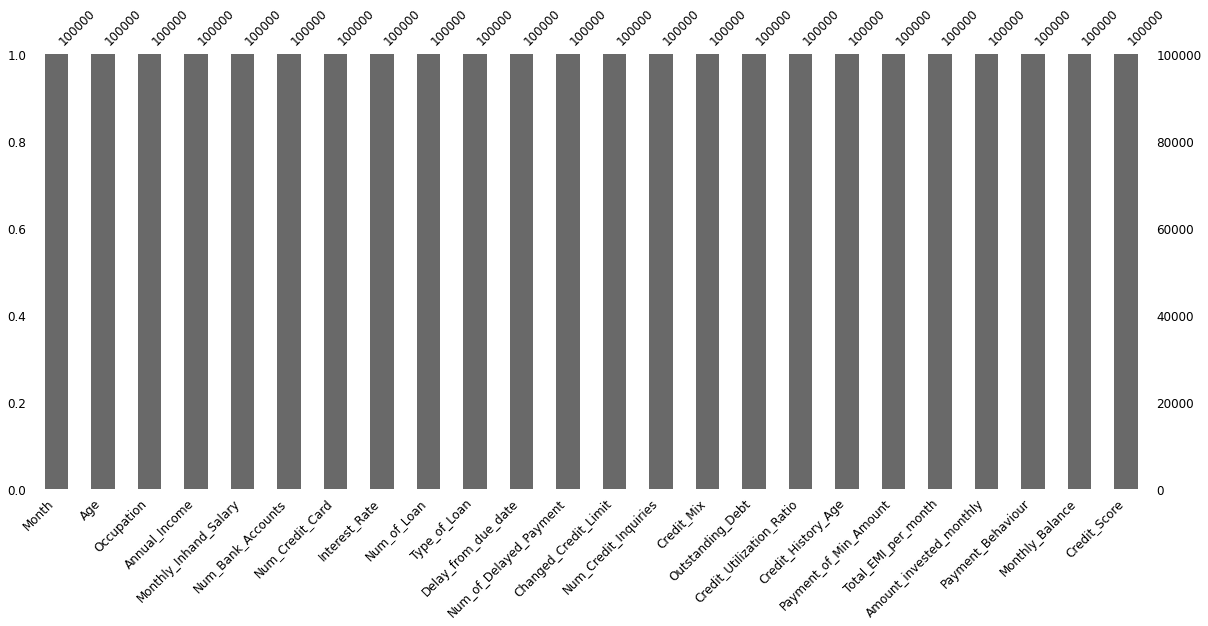

In [20]:
train_df_ = train_df_.fillna(value= 'NAH')
msno.bar(train_df_.toPandas(), figsize = (20, 8), fontsize = 12)

In [21]:
from pyspark.sql.functions import when, lit

train_df_ = train_df_.withColumn("Occupation", when(train_df_["Occupation"] == "_______", lit("None")).otherwise(train_df_["Occupation"]))
train_df_ = train_df_.withColumn("Credit_Mix", when(train_df_["Credit_Mix"] == "_", lit("None")).otherwise(train_df_["Credit_Mix"]))
train_df_ = train_df_.withColumn("Payment_Behaviour", when(train_df_["Payment_Behaviour"] == "!@9#%8", lit("None")).otherwise(train_df_["Payment_Behaviour"]))
train_df_ = train_df_.withColumn("Credit_History_Age", when(train_df_["Credit_History_Age"] == "", lit("None")).otherwise(train_df_["Credit_History_Age"]))
train_df_.show()

+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+
|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|Monthly_Balance|Credit_Score|
+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------

In [22]:
df = train_df_.toPandas()
df.Occupation.unique()

array(['Scientist', 'None', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

### Encoder các cột dữ liệu Catergorical

In [23]:
from pyspark.ml.feature import StringIndexer

feature_encoder = ['Month', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Payment_Behaviour']

for f_ in feature_encoder:
    print(f_)
    indexer = StringIndexer(inputCol = f_, outputCol = f"{f_}_StringIndexer")
    train_df_ = indexer.fit(train_df_).transform(train_df_)

Month
Type_of_Loan
Credit_Mix
Credit_History_Age
Payment_of_Min_Amount
Payment_Behaviour


In [24]:
train_df_.show()

+--------+----+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+-------------------+--------------------------+------------------------+--------------------------------+-----------------------------------+-------------------------------+
|   Month| Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|Monthly_Balance|Cre

### Model Votting

In [25]:
numericCols = ['Age', 'Annual_Income', 'Num_of_Loan', 'Changed_Credit_Limit', 'Outstanding_Debt']
for col_name in numericCols:
    train_df_ = train_df_.withColumn(col_name, train_df_[col_name].cast("float"))

In [26]:
from pyspark.ml.feature import VectorAssembler
numericCols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary',
                'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
                'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
                'Month_StringIndexer','Type_of_Loan_StringIndexer', 'Num_Credit_Inquiries',
                'Outstanding_Debt', 'Credit_Utilization_Ratio',
                'Total_EMI_per_month', 'Amount_invested_monthly', 
                'Credit_Mix_StringIndexer','Credit_History_Age_StringIndexer',
                'Monthly_Balance', 'Payment_of_Min_Amount_StringIndexer','Payment_Behaviour_StringIndexer']

assembler = VectorAssembler(inputCols= numericCols, outputCol = "features_vector", handleInvalid = "skip")
output = assembler.transform(train_df_)
output.show(5)

+--------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+-------------------+--------------------------+------------------------+--------------------------------+-----------------------------------+-------------------------------+--------------------+
|   Month|   Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Beha

In [27]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol = 'Credit_Score', outputCol = 'Label')
outputFixed = indexer.fit(output).transform(output)
outputFixed.show(5)

+--------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+-------------------+--------------------------+------------------------+--------------------------------+-----------------------------------+-------------------------------+--------------------+-----+
|   Month|   Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Paymen

In [28]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol = "features_vector", outputCol = "features_scalerl")
scalerl = scaler.fit(outputFixed).transform(outputFixed)
scalerl.show()

+--------+------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+-------------------+--------------------------+------------------------+--------------------------------+-----------------------------------+-------------------------------+--------------------+-----+--------------------+
|   Month|   Age|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_inves

### **Xử lý mất cân bằng với phương pháp Undersampling**

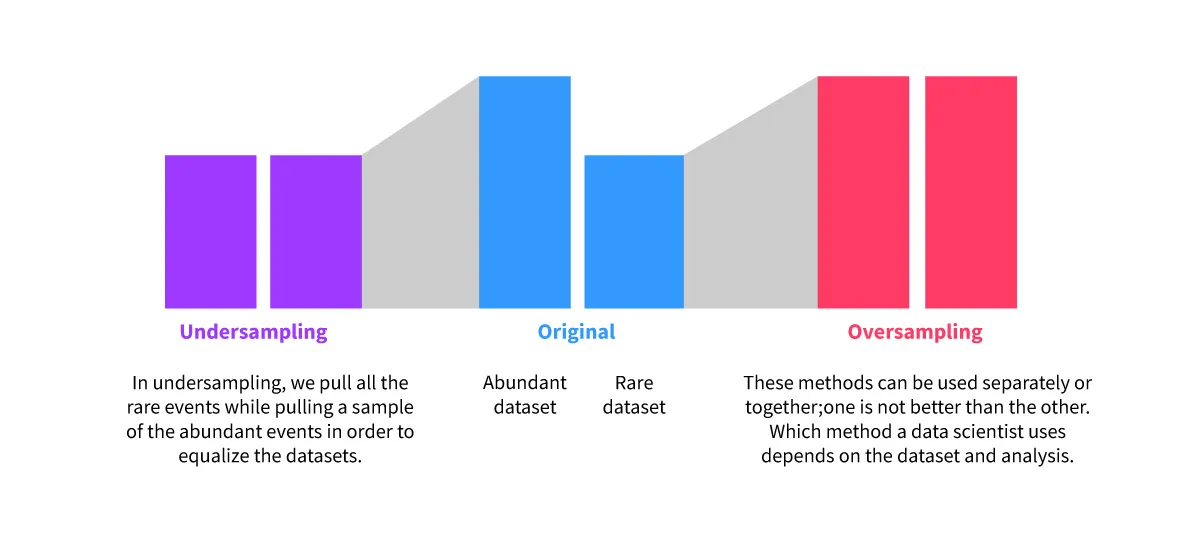

In [33]:
from pyspark.sql.functions import col, rand

label_1_df = scalerl.filter(col("Label") == 1)
count_label_1 = label_1_df.count() # 27327

label_0_df = scalerl.filter(col("Label") == 0).orderBy(rand()).limit(count_label_1)
balanced_df = label_1_df.union(label_0_df)
balanced_df.show()

+--------+------+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+--------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+-------------------+--------------------------+------------------------+--------------------------------+-----------------------------------+-------------------------------+--------------------+-----+--------------------+
|   Month|   Age|   Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|  Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount

In [34]:
num_rows = balanced_df.count()
# In ra kích thước của balanced_df
print("Kích thước của balanced_df:", num_rows)

Kích thước của balanced_df: 54654


In [37]:
data_train = balanced_df.select('features_scalerl', 'Label')
data_train.show(10)

+--------------------+-----+
|    features_scalerl|Label|
+--------------------+-----+
|[11.0494032710515...|  1.0|
|[0.04373114751075...|  1.0|
|[0.04373114751075...|  1.0|
|[0.04373114751075...|  1.0|
|[0.04373114751075...|  1.0|
|[0.05685049176398...|  1.0|
|[0.05685049176398...|  1.0|
|[0.05685049176398...|  1.0|
|[0.05685049176398...|  1.0|
|[0.05685049176398...|  1.0|
+--------------------+-----+
only showing top 10 rows



In [36]:
train_data , test_data = data_train.randomSplit([0.8, 0.2], seed = 42)
print("Dữ liệu Huấn luyện - Train: {}\nDữ liệu Thử nghiệm - Test : {}".format(balanced_df.count(), test_data.count()))

Dữ liệu Huấn luyện - Train: 43868
Dữ liệu Thử nghiệm - Test : 10786


In [45]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [77]:
def tunning_model(model, train_data, test_data):
    classifer = model.fit(train_data)
    predictions = classifer.transform(test_data)

    y_pred = predictions.select("prediction").collect()
    y_true = predictions.select("Label").collect()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()

    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, recall, prec, f1, classification_report(y_true, y_pred), predictions

**Thuật toán Random Forest with Entropy**

Độ chính xác: 0.7904691266456517
Recall: 0.7544910179640718
Precision: 0.8096385542168675
F1: 0.7810925997675319
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      5442
         1.0       0.81      0.75      0.78      5344

    accuracy                           0.79     10786
   macro avg       0.79      0.79      0.79     10786
weighted avg       0.79      0.79      0.79     10786



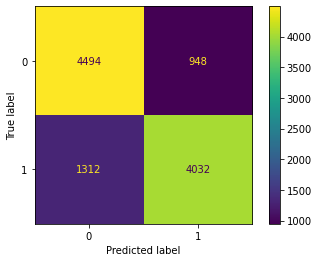

In [79]:
rf = RandomForestClassifier(labelCol = "Label", featuresCol = "features_scalerl",
                            numTrees = 101,
                            maxDepth = 25,
                            seed = 42,
                            impurity = 'entropy')
acc_, recall, prec, f1, report, predictions_rf_entropy = tunning_model(rf, train_data, test_data)
print("Độ chính xác:", acc_)
print("Recall:", recall)
print("Precision:", prec)
print("F1:", f1)
print(report)

**Thuật toán Random Forest with Gini**

Độ chính xác: 0.7878731689226776
Recall: 0.7453218562874252
Precision: 0.8112016293279022
F1: 0.7768675638775113
              precision    recall  f1-score   support

         0.0       0.77      0.83      0.80      5442
         1.0       0.81      0.75      0.78      5344

    accuracy                           0.79     10786
   macro avg       0.79      0.79      0.79     10786
weighted avg       0.79      0.79      0.79     10786



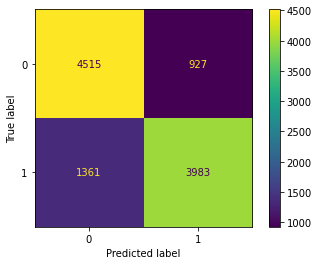

In [135]:
rf = RandomForestClassifier(labelCol = "Label", featuresCol = "features_scalerl",
                            numTrees = 101,
                            maxDepth = 25,
                            seed = 42,
                            impurity = 'gini')
acc_, recall, prec, f1, report, predictions_rf_gini = tunning_model(rf, train_data, test_data)
print("Độ chính xác:", acc_)
print("Recall:", recall)
print("Precision:", prec)
print("F1:", f1)
print(report)

**Thuật toán GBTClassifier**

Độ chính xác: 0.8090116818097534
Recall: 0.8055763473053892
Precision: 0.8082989110026286
F1: 0.8069353327085286
              precision    recall  f1-score   support

         0.0       0.81      0.81      0.81      5442
         1.0       0.81      0.81      0.81      5344

    accuracy                           0.81     10786
   macro avg       0.81      0.81      0.81     10786
weighted avg       0.81      0.81      0.81     10786



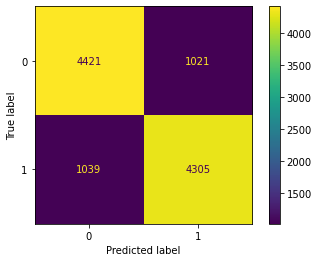

In [136]:
gbt = GBTClassifier(labelCol = "Label", featuresCol = "features_scalerl")
acc_, recall, prec, f1, report, predictions_gbt = tunning_model(gbt, train_data, test_data)
print("Độ chính xác:", acc_)
print("Recall:", recall)
print("Precision:", prec)
print("F1:", f1)
print(report)

In [152]:
param_map = gbt.extractParamMap()
for param in param_map:
    print(param.name, param_map[param])

seed 2133211881457252562
maxDepth 5
maxBins 32
minInstancesPerNode 1
minInfoGain 0.0
maxMemoryInMB 256
cacheNodeIds False
checkpointInterval 10
lossType logistic
maxIter 20
stepSize 0.1
subsamplingRate 1.0
impurity variance
featureSubsetStrategy all
validationTol 0.01
leafCol 
minWeightFractionPerNode 0.0
predictionCol prediction
featuresCol features_scalerl
labelCol Label
rawPredictionCol rawPrediction
probabilityCol probability


**Thuật toán MultilayerPerceptronClassifier**

Độ chính xác: 0.7760059336176525
Recall: 0.7612275449101796
Precision: 0.7811059907834101
F1: 0.7710386656557999
              precision    recall  f1-score   support

         0.0       0.77      0.79      0.78      5442
         1.0       0.78      0.76      0.77      5344

    accuracy                           0.78     10786
   macro avg       0.78      0.78      0.78     10786
weighted avg       0.78      0.78      0.78     10786



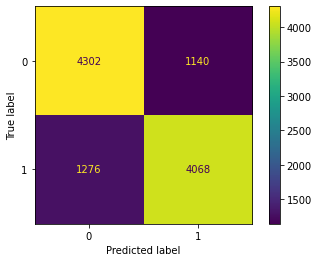

In [137]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [len(assembler.getInputCols()),64, 16, 8, 2]

mlp = MultilayerPerceptronClassifier(labelCol='Label',featuresCol='features_scalerl',maxIter=100,layers=layers,blockSize=128,seed=100)
acc_, recall, prec, f1, report, predictions_mlp = tunning_model(mlp, train_data, test_data)
print("Độ chính xác:", acc_)
print("Recall:", recall)
print("Precision:", prec)
print("F1:", f1)
print(report)

In [151]:
param_map = mlp.extractParamMap()
for param in param_map:
    print(param.name, param_map[param])

solver l-bfgs
seed 100
predictionCol prediction
featuresCol features_scalerl
labelCol Label
rawPredictionCol rawPrediction
probabilityCol probability
maxIter 100
tol 1e-06
blockSize 128
stepSize 0.03
layers [22, 128, 64, 32, 16, 8, 2]


In [138]:
predictions_rf_entropy = predictions_rf_entropy.withColumnRenamed("prediction", "predictions_rf_entropy")
predictions_gbt = predictions_gbt.withColumnRenamed("prediction", "predictions_gbt")
predictions_mlp = predictions_mlp.withColumnRenamed("prediction", "predictions_mlp")

rf_pred = predictions_rf_entropy.select("predictions_rf_entropy")
gbt_pred = predictions_gbt.select("predictions_gbt")
mlp_pred = predictions_mlp.select("predictions_mlp")

In [139]:
from pyspark.sql.functions import monotonically_increasing_id

rf_pred = rf_pred.withColumn("id", monotonically_increasing_id())
gbt_pred = gbt_pred.withColumn("id", monotonically_increasing_id())
mlp_pred = mlp_pred.withColumn("id", monotonically_increasing_id())

combined_pred = rf_pred.join(gbt_pred, "id").join(mlp_pred, "id")
combined_pred.show(10)

+---+----------------------+---------------+---------------+
| id|predictions_rf_entropy|predictions_gbt|predictions_mlp|
+---+----------------------+---------------+---------------+
|  0|                   1.0|            1.0|            1.0|
|  1|                   1.0|            1.0|            1.0|
|  2|                   1.0|            1.0|            1.0|
|  3|                   0.0|            0.0|            0.0|
|  4|                   1.0|            1.0|            1.0|
|  5|                   0.0|            1.0|            0.0|
|  6|                   1.0|            1.0|            1.0|
|  7|                   0.0|            0.0|            0.0|
|  8|                   1.0|            1.0|            1.0|
|  9|                   1.0|            1.0|            1.0|
+---+----------------------+---------------+---------------+
only showing top 10 rows



In [140]:
combined_pred = combined_pred.withColumn("voted_result", 
                   when((col("predictions_rf_entropy") == col("predictions_gbt")) & (col("predictions_rf_entropy") == col("predictions_mlp")), col("predictions_rf_entropy"))
                   .when((col("predictions_rf_entropy") == col("predictions_gbt")), col("predictions_rf_entropy"))
                   .when((col("predictions_rf_entropy") == col("predictions_mlp")), col("predictions_rf_entropy"))
                   .when((col("predictions_gbt") == col("predictions_mlp")), col("predictions_gbt"))
                   .otherwise(col("predictions_rf_entropy")))

# Hiển thị kết quả
combined_pred.show()

+---+----------------------+---------------+---------------+------------+
| id|predictions_rf_entropy|predictions_gbt|predictions_mlp|voted_result|
+---+----------------------+---------------+---------------+------------+
|  0|                   1.0|            1.0|            1.0|         1.0|
|  1|                   1.0|            1.0|            1.0|         1.0|
|  2|                   1.0|            1.0|            1.0|         1.0|
|  3|                   0.0|            0.0|            0.0|         0.0|
|  4|                   1.0|            1.0|            1.0|         1.0|
|  5|                   0.0|            1.0|            0.0|         0.0|
|  6|                   1.0|            1.0|            1.0|         1.0|
|  7|                   0.0|            0.0|            0.0|         0.0|
|  8|                   1.0|            1.0|            1.0|         1.0|
|  9|                   1.0|            1.0|            1.0|         1.0|
| 10|                   1.0|          

Độ chính xác: 0.7936213610235491
Recall: 0.7642215568862275
Precision: 0.8087128712871288
F1: 0.7858379834519915
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      5442
         1.0       0.81      0.76      0.79      5344

    accuracy                           0.79     10786
   macro avg       0.79      0.79      0.79     10786
weighted avg       0.79      0.79      0.79     10786



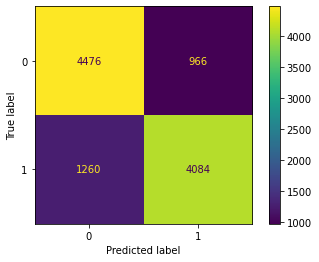

In [141]:
y_pred = combined_pred.select("voted_result").collect()
y_true = test_data.select("Label").collect()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

print("Độ chính xác:", accuracy_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("F1:", f1_score(y_true, y_pred))
print(classification_report(y_true, y_pred))